In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from loader import load_models, MODEL_ORDER, MODEL_COLORS, PANEL_DATA_PATH

# Only load columns needed for trajectory analysis
usecols = ["game_id", "player_id", "turn", "turn_progress", "civilization", "is_winner", "predicted_win_probability"]
models = load_models(usecols=usecols)

model_names = [m for m in MODEL_ORDER if m in models]
print(f"\nModels found: {model_names}")

Loaded naive: 1,875,256 rows
Loaded score: 1,875,256 rows
Loaded baseline: 1,875,256 rows
Loaded xgboost: 1,875,256 rows
Loaded mlp: 1,875,256 rows
Loaded grouped_mlp: 1,875,256 rows
Loaded interaction_mlp: 1,875,256 rows
Loaded attention_mlp: 1,875,256 rows

Models found: ['naive', 'score', 'baseline', 'xgboost', 'mlp', 'grouped_mlp', 'interaction_mlp', 'attention_mlp']


## 4a. Average Probability Paths
Mean predicted win probability over game progress for eventual winners vs losers.  
Shows when each model starts "figuring out" who will win.

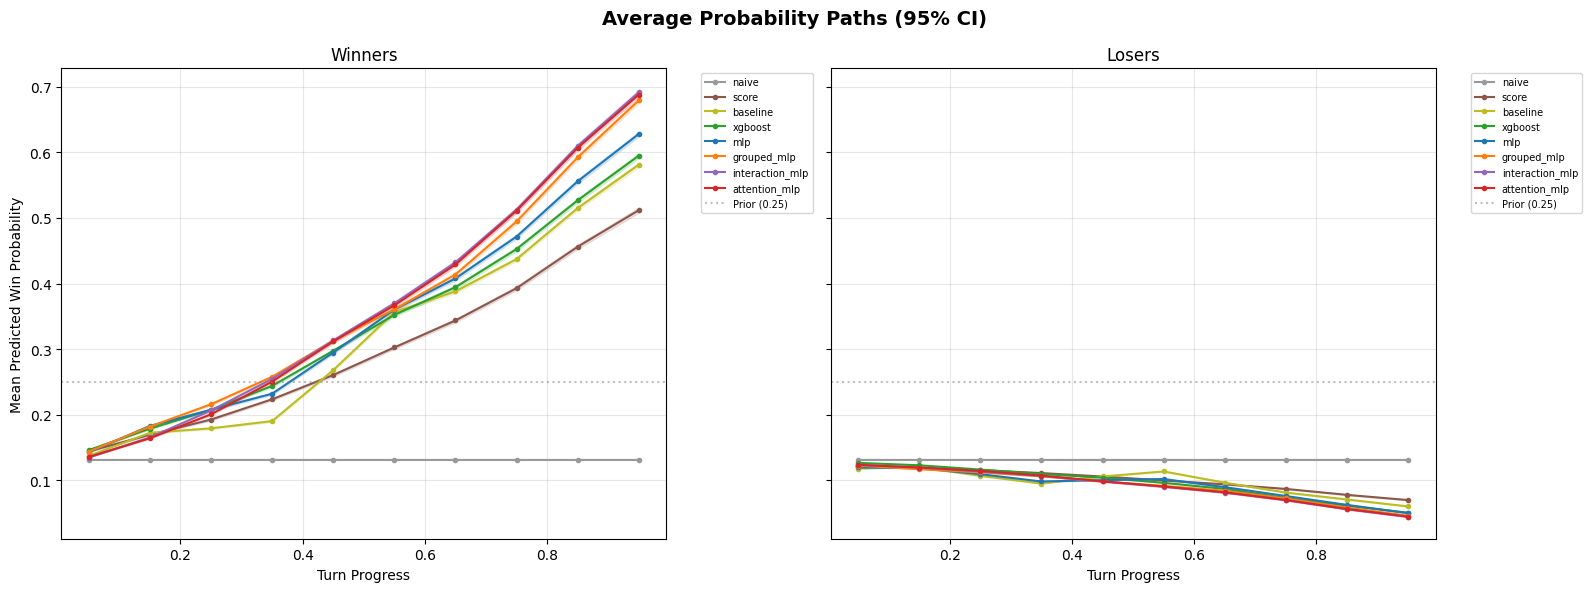

In [2]:
from scipy import stats

bins = np.arange(0, 1.1, 0.1)
labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins) - 1)]
bin_centers = (bins[:-1] + bins[1:]) / 2

z_score = stats.norm.ppf((1 + 0.95) / 2)

fig, (ax_w, ax_l) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for name in model_names:
    df = models[name].copy()
    color = MODEL_COLORS[name]
    df["bin"] = pd.cut(df["turn_progress"], bins=bins, labels=labels, right=False)

    for outcome, ax in [(1, ax_w), (0, ax_l)]:
        grp = df[df["is_winner"] == outcome].groupby("bin", observed=True)["predicted_win_probability"]
        agg = grp.agg(["mean", "sem"]).dropna()
        ci_lower = agg["mean"] - z_score * agg["sem"]
        ci_upper = agg["mean"] + z_score * agg["sem"]
        x = bin_centers[:len(agg)]
        ax.plot(x, agg["mean"].values, marker="o", markersize=3,
                color=color, label=name)
        ax.fill_between(x, ci_lower.values, ci_upper.values,
                        color=color, alpha=0.15)

for ax, title in [(ax_w, "Winners"), (ax_l, "Losers")]:
    ax.axhline(y=0.25, color="gray", linestyle=":", alpha=0.5, label="Prior (0.25)")
    ax.set_xlabel("Turn Progress")
    ax.set_title(title)
    ax.legend(fontsize=7, bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.grid(True, alpha=0.3)

ax_w.set_ylabel("Mean Predicted Win Probability")
fig.suptitle("Average Probability Paths (95% CI)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

## 4b. Comeback / Surprise Games
Games where the eventual winner had predicted probability < 0.15 at turn_progress > 0.7.  
These are games that the model(s) got wrong late in the game — potential comebacks.

In [3]:
# Use an available neural model
ref_model = "interaction_mlp" if "interaction_mlp" in models else model_names[0]
ref_df = models[ref_model]

# Winners late in the game with low predicted probability
late_winners = ref_df[
    (ref_df["is_winner"] == 1) &
    (ref_df["turn_progress"] > 0.9) &
    (ref_df["predicted_win_probability"] < 0.15)
]

surprise_games = late_winners["game_id"].unique()
print(f"Model: {ref_model}")
print(f"Surprise/comeback games found: {len(surprise_games)}")
print(f"Total unique games: {ref_df['game_id'].nunique()}")
print(f"Proportion: {len(surprise_games) / ref_df['game_id'].nunique():.1%}")

Model: interaction_mlp
Surprise/comeback games found: 100
Total unique games: 551
Proportion: 18.1%


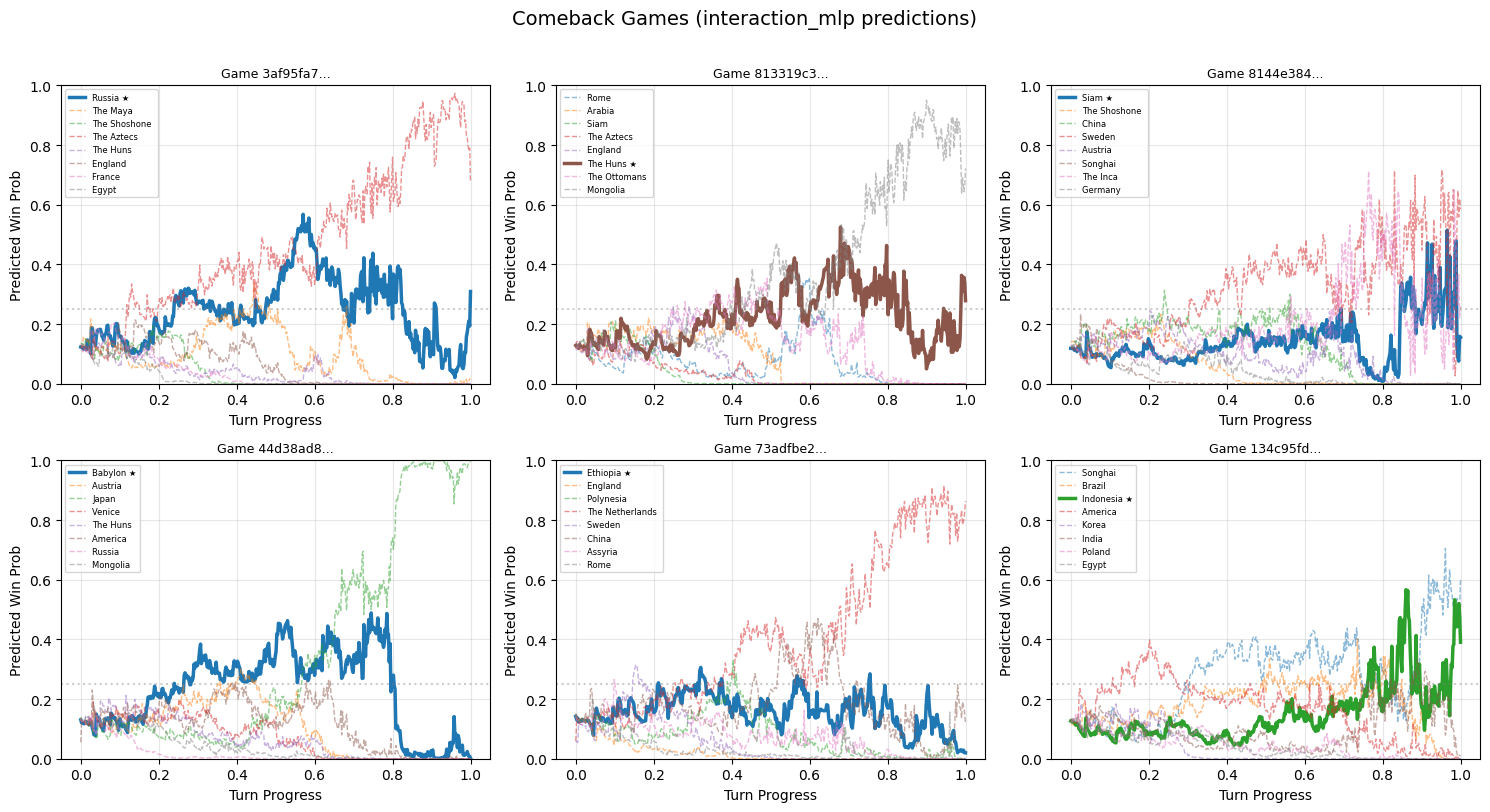

In [4]:
# Plot up to 6 example comeback game trajectories
n_examples = min(6, len(surprise_games))
example_games = surprise_games[:n_examples]

if n_examples > 0:
    cols = min(3, n_examples)
    rows = (n_examples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), squeeze=False)

    for idx, game_id in enumerate(example_games):
        ax = axes[idx // cols][idx % cols]
        game_data = ref_df[ref_df["game_id"] == game_id].sort_values("turn")

        for pid, player_data in game_data.groupby("player_id"):
            is_winner = player_data["is_winner"].iloc[0]
            civ = player_data["civilization"].iloc[0]
            style = "-" if is_winner else "--"
            lw = 2.5 if is_winner else 1.0
            alpha = 1.0 if is_winner else 0.5
            label = f"{civ} {'★' if is_winner else ''}"
            ax.plot(player_data["turn_progress"], player_data["predicted_win_probability"],
                    linestyle=style, linewidth=lw, alpha=alpha, label=label)

        ax.axhline(y=0.25, color="gray", linestyle=":", alpha=0.4)
        ax.set_xlabel("Turn Progress")
        ax.set_ylabel("Predicted Win Prob")
        ax.set_title(f"Game {game_id[:8]}...", fontsize=9)
        ax.legend(fontsize=6)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1)

    for idx in range(n_examples, rows * cols):
        axes[idx // cols][idx % cols].set_visible(False)

    fig.suptitle(f"Comeback Games ({ref_model} predictions)", fontsize=14, y=1.01)
    plt.tight_layout()
    plt.show()
else:
    print("No comeback games found with the current threshold.")

## 4c. Comeback Game Profiles
Victory type and civilization distributions for comeback winners vs all winners.

In [5]:
# Load panel_data to get victory_type for each game
panel = pd.read_csv(PANEL_DATA_PATH, usecols=["game_id", "player_id", "victory_type", "civilization", "is_winner", "turn"])

# One row per game-winner (deduplicate across turns)
all_winners = (
    panel[panel["is_winner"] == 1]
    .sort_values("turn")
    .drop_duplicates(subset=["game_id", "player_id"], keep="first")
)

# Comeback winners subset
comeback_winners = all_winners[all_winners["game_id"].isin(surprise_games)]

print(f"All winners: {len(all_winners)}")
print(f"Comeback winners: {len(comeback_winners)}")
print(f"\nComeback victory types:\n{comeback_winners['victory_type'].value_counts()}")
print(f"\nComeback civilizations:\n{comeback_winners['civilization'].value_counts()}")

All winners: 551
Comeback winners: 100

Comeback victory types:
victory_type
Diplomatic    39
Science       29
Cultural      27
Time           5
Name: count, dtype: int64

Comeback civilizations:
civilization
Austria            6
China              6
The Netherlands    5
Carthage           5
The Inca           4
Byzantium          4
The Celts          4
Poland             4
Germany            4
Siam               4
Ethiopia           4
Babylon            3
The Iroquois       3
Venice             3
The Huns           3
Russia             3
The Maya           3
Brazil             3
The Shoshone       2
The Aztecs         2
Portugal           2
India              2
Korea              2
Greece             2
France             2
Spain              2
Indonesia          2
Arabia             1
Persia             1
Denmark            1
America            1
Morocco            1
Egypt              1
Japan              1
England            1
Assyria            1
Sweden             1
The Zulus     

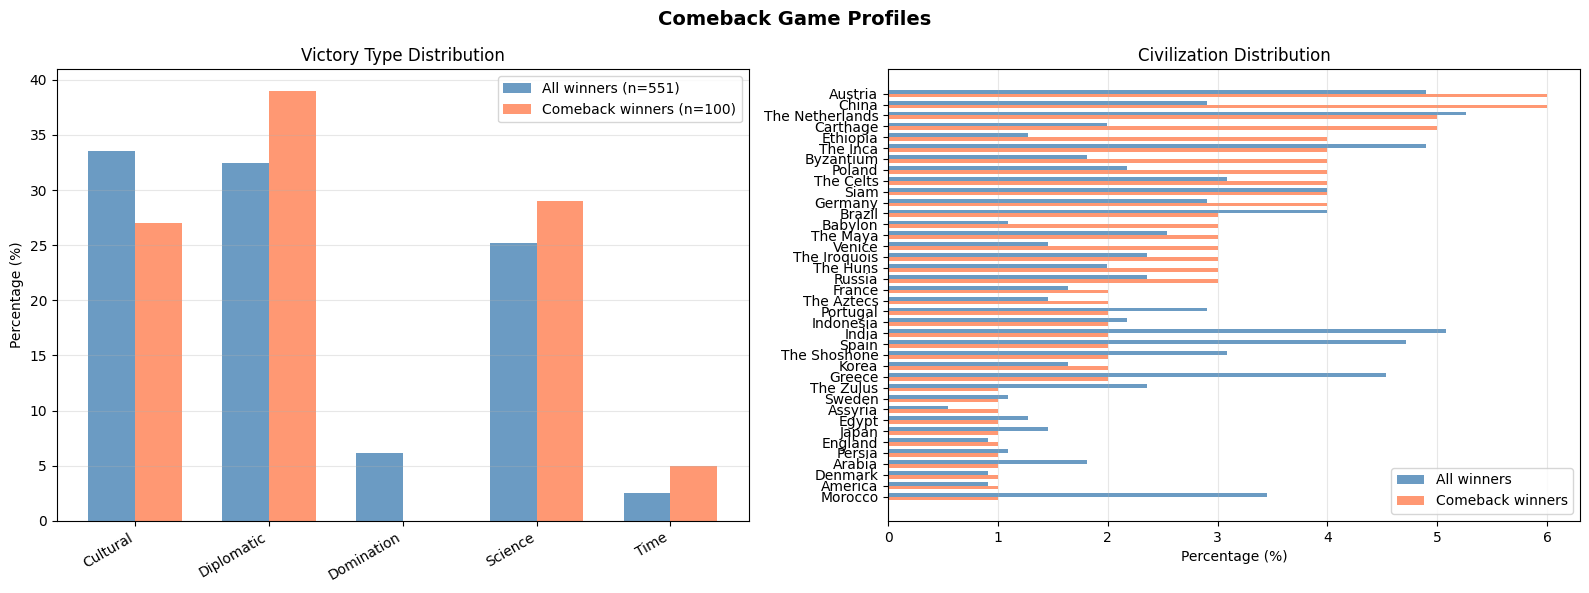

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- Left: Victory Type distribution ---
all_vt = all_winners["victory_type"].value_counts(normalize=True).sort_index()
cb_vt = comeback_winners["victory_type"].value_counts(normalize=True).sort_index()

# Align indices
vt_labels = sorted(set(all_vt.index) | set(cb_vt.index))
all_vt = all_vt.reindex(vt_labels, fill_value=0)
cb_vt = cb_vt.reindex(vt_labels, fill_value=0)

x = np.arange(len(vt_labels))
w = 0.35
ax1.bar(x - w / 2, all_vt.values * 100, w, label=f"All winners (n={len(all_winners)})", color="steelblue", alpha=0.8)
ax1.bar(x + w / 2, cb_vt.values * 100, w, label=f"Comeback winners (n={len(comeback_winners)})", color="coral", alpha=0.8)
ax1.set_xticks(x)
ax1.set_xticklabels(vt_labels, rotation=30, ha="right")
ax1.set_ylabel("Percentage (%)")
ax1.set_title("Victory Type Distribution")
ax1.legend()
ax1.grid(True, alpha=0.3, axis="y")

# --- Right: Civilization distribution ---
all_civ = all_winners["civilization"].value_counts(normalize=True)
cb_civ = comeback_winners["civilization"].value_counts(normalize=True)

# Show all civs that appear in comebacks, sorted by comeback frequency
civ_labels = cb_civ.sort_values().index.tolist()
all_civ = all_civ.reindex(civ_labels, fill_value=0)
cb_civ = cb_civ.reindex(civ_labels, fill_value=0)

y = np.arange(len(civ_labels))
h = 0.35
ax2.barh(y + h / 2, all_civ.values * 100, h, label=f"All winners", color="steelblue", alpha=0.8)
ax2.barh(y - h / 2, cb_civ.values * 100, h, label=f"Comeback winners", color="coral", alpha=0.8)
ax2.set_yticks(y)
ax2.set_yticklabels(civ_labels)
ax2.set_xlabel("Percentage (%)")
ax2.set_title("Civilization Distribution")
ax2.legend()
ax2.grid(True, alpha=0.3, axis="x")

fig.suptitle("Comeback Game Profiles", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()